In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [55]:
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 50
G_HIDDEN = 64
EPOCH_NUM = 100
lr = 2e-4

In [56]:
dataset = dset.FashionMNIST(root="./data", download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2, drop_last=True)

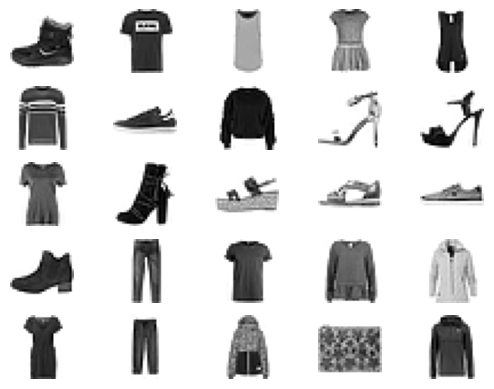

In [57]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis("off")
    plt.imshow(dataset.__getitem__(i)[0].reshape(28, 28), cmap="gray_r")
plt.show()

In [58]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [59]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(n_classes, 50)
        self.ll1 = nn.LazyLinear(28**2)
        self.conv1 = nn.Conv2d(2, 128, 3, 2, 1, bias=False)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(128, 128, 3, 2, 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(6272, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_t, in_label=torch.Tensor([[0], [0]]).to(device, dtype=int)):
        lab = self.embed(in_label)
        lab = self.ll1(lab)
        lab = lab.view(-1, 1, 28, 28)
        input_t = torch.concatenate((input_t, lab.to(device)), dim=1)
        x = self.conv1(input_t)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.batch_norm(x)
        x = self.leaky_relu2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [60]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_space, n_classes=10):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(n_classes, 50)
        self.ll1 = nn.LazyLinear(7**2)
        self.latent_space = latent_space
        self.fc = nn.Linear(in_features=self.latent_space, out_features=128*7*7)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=129, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        self.conv2d = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=(7, 7), padding='same')
        self.tanh = nn.Tanh()

    def forward(self, x, input_class=torch.Tensor([[0],[0]]).to(device, dtype=int)):
        input_class = self.embedding(input_class)
        input_class = self.ll1(input_class)
        input_class = input_class.view(-1, 1, 7, 7)
        x = self.fc(x)
        x = self.leaky_relu(x)
        x = x.view(-1, 128, 7, 7)
        x = torch.concatenate((x, input_class), dim=1)
        x = self.conv_transpose1(x)
        x = self.leaky_relu(x)
        x = self.conv_transpose2(x)
        x = self.leaky_relu(x)
        x = self.conv2d(x)
        x = self.tanh(x)
        return x

In [61]:
from torchsummary import summary
netG = Generator(Z_DIM).to(device)
netG.apply(weights_init)

netD = Discriminator(10).to(device)
netD.apply(weights_init)

summary(netD, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                [-1, 1, 50]             500
            Linear-2               [-1, 1, 784]          39,984
            Conv2d-3          [-1, 128, 14, 14]           2,304
         LeakyReLU-4          [-1, 128, 14, 14]               0
            Conv2d-5            [-1, 128, 7, 7]         147,456
       BatchNorm2d-6            [-1, 128, 7, 7]             256
         LeakyReLU-7            [-1, 128, 7, 7]               0
           Flatten-8                 [-1, 6272]               0
           Dropout-9                 [-1, 6272]               0
           Linear-10                    [-1, 1]           6,273
          Sigmoid-11                    [-1, 1]               0
Total params: 196,773
Trainable params: 196,773
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [62]:
summary(netG, (1, 1, Z_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                [-1, 1, 50]             500
            Linear-2                [-1, 1, 49]           2,499
            Linear-3           [-1, 1, 1, 6272]         319,872
         LeakyReLU-4           [-1, 1, 1, 6272]               0
   ConvTranspose2d-5          [-1, 128, 14, 14]         264,320
         LeakyReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7          [-1, 128, 28, 28]         262,272
         LeakyReLU-8          [-1, 128, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]           6,273
             Tanh-10            [-1, 1, 28, 28]               0
Total params: 855,736
Trainable params: 855,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.02
Params size (MB): 3.26
Estimated T

In [63]:
viz_noise = torch.randn(BATCH_SIZE, 1, 1, Z_DIM, device=device)
viz_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device)

criterion = nn.MSELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr*1e-2, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [64]:
import os
def save_image(img_list, epoch):
    plt.figure(figsize=(16, 16));
    plt.axis("off")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    if not os.path.exists('generated'):
        os.makedirs('generated')
    plt.savefig("generated/img%d.png" % epoch, bbox_inches='tight', pad_inches=0)  

In [ ]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

img_list = []
iters = 0

now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
logdir = f"trainings/{timestamp}/"
writer = SummaryWriter(logdir)
global_step = 0

for epoch in range(EPOCH_NUM):
    batch_iterator = tqdm(dataloader, desc=f"Processing Epoch {epoch+1:02d}")
    torch.cuda.empty_cache()
    for i, data in enumerate(batch_iterator, 0):
        netD.train()
        netG.train()

        netD.zero_grad()
        x_real = data[0].to(device) # tuple (IMG, N°.)
        x_label = data[1].to(device)
        y_hat = torch.full((BATCH_SIZE,), 1, dtype=torch.float, device=device)
        output = netD(x_real, x_label).view(-1)
        errD_real = criterion(output, y_hat)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(BATCH_SIZE, 1, 1, Z_DIM, device=device)
        noise_labels = torch.randint(0, 10, (BATCH_SIZE,), device=device)
        fake = netG(noise, noise_labels)
        y_hat.fill_(0)
        output = netD(fake.detach(), noise_labels).view(-1)
        errD_fake = criterion(output, y_hat)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        y_hat.fill_(1)
        output = netD(fake, noise_labels).view(-1)
        errG = criterion(output, y_hat)
        errG.backward()
        optimizerG.step()

        writer.add_scalars('losses', {'DLoss': errD.item(), 'GLoss': errG.item()}, global_step)
        writer.flush()
        global_step += 1

        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise, viz_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if epoch % 2 == 0:
        save_image(img_list, epoch)

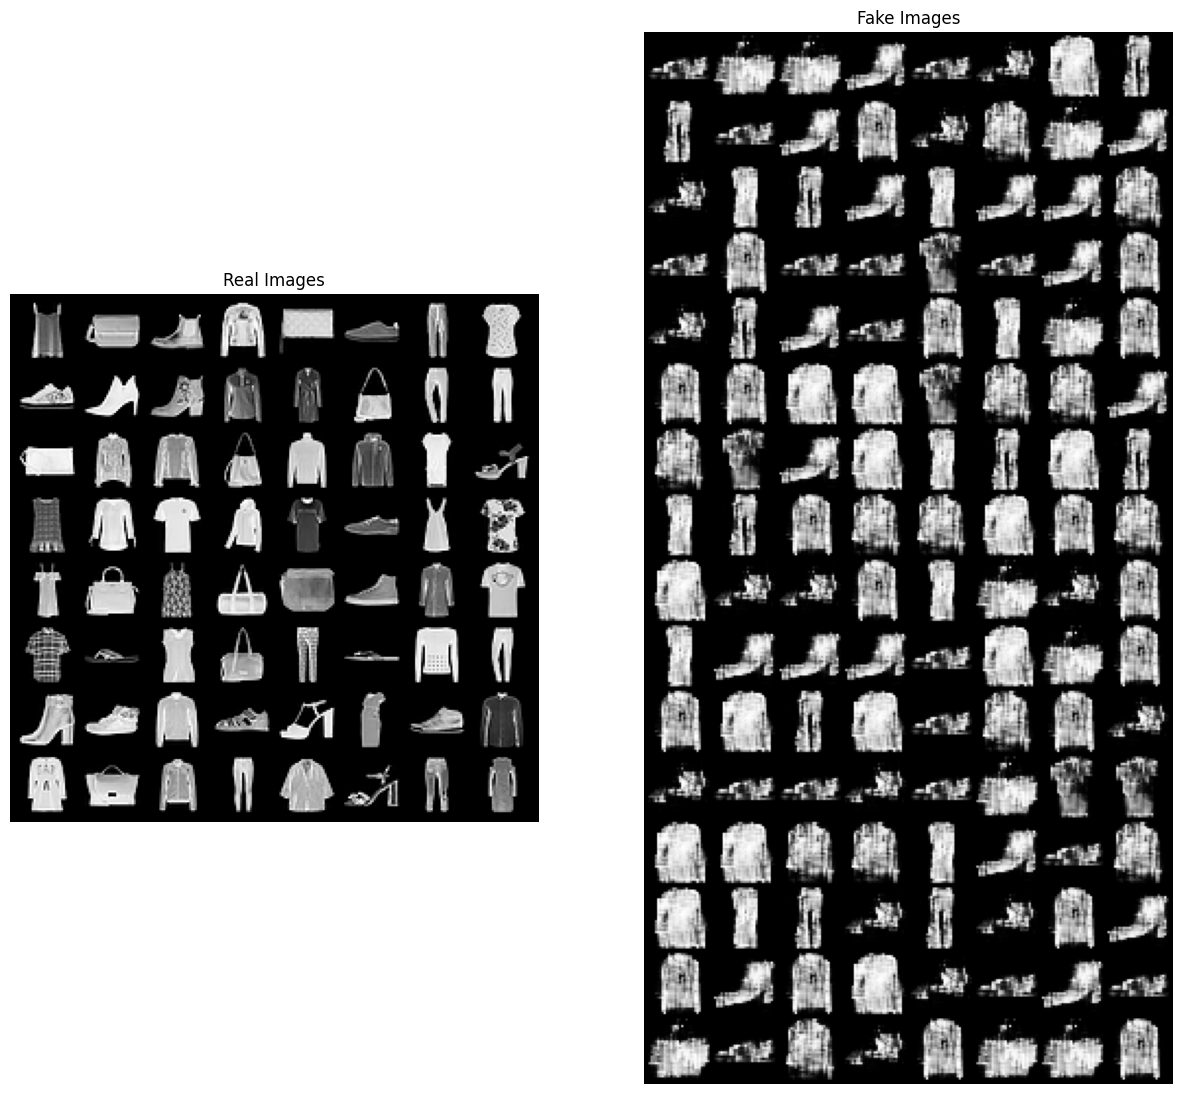

In [66]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

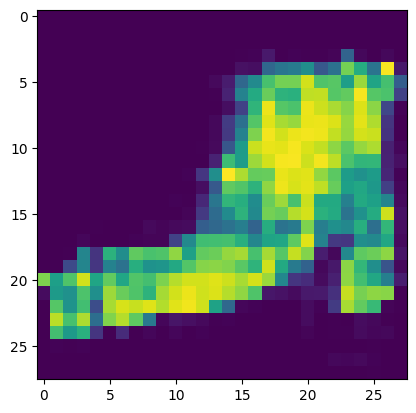

In [83]:
with torch.no_grad():
    plt.imshow(netG(torch.randn(1, 1, 1, Z_DIM, device=device), torch.Tensor([9]).to(dtype=int, device=device)).detach().cpu().reshape(28,28))

Sadly, a mode collapse had ocurred.